In [3]:
# cell 1: install requirements
!pip install pandas numpy nltk textblob matplotlib seaborn scipy

In [4]:
# cell 2: imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from scipy.stats import pearsonr
import nltk
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt')

print("All packages imported successfully!")

[nltk_data] Downloading package punkt to C:\Users\Makda
[nltk_data]     Tsegazeab\AppData\Roaming\nltk_data...


All packages imported successfully!


[nltk_data]   Package punkt is already up-to-date!


In [9]:
# cell 3: data loading functions
def load_stock_data(stock_data_path):
    """Load all stock CSV files"""
    print("Loading stock data...")
    stock_files = {
        'AAPL': 'AAPL.csv',
        'AMZN': 'AMZN.csv', 
        'GOOG': 'GOOG.csv',
        'META': 'META.csv',
        'MSFT': 'MSFT.csv',
        'NVDA': 'NVDA.csv'
    }
    
    stock_data = {}
    for ticker, filename in stock_files.items():
        file_path = os.path.join(stock_data_path, filename)
        try:
            df = pd.read_csv(file_path)
            # Ensure date column is datetime
            if 'Date' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'])
                df = df.sort_values('Date')
            stock_data[ticker] = df
            print(f"✅ Loaded {ticker}: {len(df)} rows, from {df['Date'].min().date()} to {df['Date'].max().date()}")
        except FileNotFoundError:
            print(f"❌ Warning: {filename} not found at {file_path}")
            
    return stock_data

def load_news_data(news_data_path):
    """Load and preprocess news data"""
    print("\nLoading news data...")
    try:
        # Adjust this based on your actual news file format
        if news_data_path.endswith('.csv'):
            news_data = pd.read_csv(news_data_path)
        elif news_data_path.endswith('.json'):
            news_data = pd.read_json(news_data_path)
        else:
            # Try CSV first
            news_data = pd.read_csv(news_data_path)
        
        print(f"Raw news data columns: {news_data.columns.tolist()}")
        print(f"Raw news data shape: {news_data.shape}")
        
        # Normalize date column (adjust based on your news data structure)
        date_columns = ['date', 'Date', 'published', 'timestamp', 'publish_date']
        date_col_found = None
        for col in date_columns:
            if col in news_data.columns:
                news_data['Date'] = pd.to_datetime(news_data[col]).dt.normalize()
                date_col_found = col
                print(f"✅ Using '{col}' as date column")
                break
        
        if date_col_found is None:
            print("❌ No date column found. Available columns:", news_data.columns.tolist())
            return None
            
        # Identify text column for sentiment analysis
        text_columns = ['headline', 'title', 'content', 'text', 'description']
        text_col_found = None
        for col in text_columns:
            if col in news_data.columns:
                text_col_found = col
                print(f"✅ Using '{col}' as text column for sentiment analysis")
                break
                
        if text_col_found is None:
            print("❌ No text column found. Available columns:", news_data.columns.tolist())
            return None
            
        print(f"✅ Loaded news data: {len(news_data)} articles")
        print(f"📅 Date range: {news_data['Date'].min().date()} to {news_data['Date'].max().date()}")
        
        return news_data, text_col_found
        
    except Exception as e:
        print(f"❌ Error loading news data: {e}")
        return None, None

In [10]:
# cell 4: sentiment analysis functions
def analyze_sentiment(text):
    """Perform sentiment analysis on text"""
    if pd.isna(text) or text == '' or text is None:
        return 0.0
        
    try:
        analysis = TextBlob(str(text))
        # Returns polarity score between -1 (negative) and 1 (positive)
        return analysis.sentiment.polarity
    except:
        return 0.0

def calculate_daily_sentiment(news_data, text_column):
    """Calculate average daily sentiment scores"""
    print("\nCalculating daily sentiment scores...")
    
    # Apply sentiment analysis
    news_data['sentiment'] = news_data[text_column].apply(analyze_sentiment)
    
    # Display sentiment distribution
    print(f"Sentiment score range: {news_data['sentiment'].min():.3f} to {news_data['sentiment'].max():.3f}")
    print(f"Average sentiment: {news_data['sentiment'].mean():.3f}")
    
    # Group by date and calculate statistics
    daily_sentiment = news_data.groupby('Date')['sentiment'].agg([
        'mean', 'count', 'std', 'min', 'max'
    ]).reset_index()
    
    daily_sentiment.columns = ['Date', 'avg_sentiment', 'article_count', 'sentiment_std', 'min_sentiment', 'max_sentiment']
    
    print(f"Daily sentiment calculated for {len(daily_sentiment)} days")
    print(f"Articles per day - Avg: {daily_sentiment['article_count'].mean():.1f}, Max: {daily_sentiment['article_count'].max()}")
    
    return daily_sentiment

In [11]:
# cell 5: stock returns calculation
def calculate_stock_returns(stock_data, ticker):
    """Calculate daily returns for a stock"""
    print(f"\nCalculating returns for {ticker}...")
    stock_df = stock_data[ticker].copy()
    
    # Identify price column
    price_columns = ['Close', 'close', 'Adj Close', 'adj_close']
    price_col = None
    for col in price_columns:
        if col in stock_df.columns:
            price_col = col
            break
            
    if price_col is None:
        print(f"❌ No price column found for {ticker}. Available: {stock_df.columns.tolist()}")
        return None
        
    # Calculate daily percentage returns
    stock_df['daily_return'] = stock_df[price_col].pct_change() * 100
    stock_df['daily_return_pct'] = stock_df[price_col].pct_change()
    
    # Remove first row (NaN return)
    stock_df = stock_df.dropna(subset=['daily_return'])
    
    print(f"✅ {ticker} returns calculated: {len(stock_df)} trading days")
    print(f"📊 Return stats - Min: {stock_df['daily_return'].min():.2f}%, Max: {stock_df['daily_return'].max():.2f}%, Avg: {stock_df['daily_return'].mean():.2f}%")
    
    return stock_df[['Date', 'daily_return', 'daily_return_pct', price_col]]

In [12]:
# cell 6: correlation analysis functions
def merge_sentiment_returns(daily_sentiment, stock_returns, ticker):
    """Merge sentiment and stock returns data"""
    merged_data = pd.merge(daily_sentiment, stock_returns, on='Date', how='inner')
    merged_data = merged_data.dropna()
    merged_data['ticker'] = ticker
    
    print(f"✅ Merged data for {ticker}: {len(merged_data)} matched days")
    return merged_data

def calculate_correlation(merged_data, ticker):
    """Calculate correlation between sentiment and stock returns"""
    if len(merged_data) < 2:
        print(f"❌ Not enough data points for {ticker}")
        return None, None
    
    # Calculate Pearson correlation
    correlation, p_value = pearsonr(merged_data['avg_sentiment'], merged_data['daily_return'])
    
    print(f"\n📈 Correlation Analysis for {ticker}:")
    print(f"   Pearson Correlation: {correlation:.4f}")
    print(f"   P-value: {p_value:.4f}")
    print(f"   Sample size: {len(merged_data)} days")
    print(f"   Interpretation: {'Significant' if p_value < 0.05 else 'Not significant'} at 95% confidence")
    
    return correlation, p_value

def analyze_all_stocks(daily_sentiment, stock_data, stock_returns):
    """Run correlation analysis for all stocks"""
    print("\n" + "="*60)
    print("COMPREHENSIVE CORRELATION ANALYSIS")
    print("="*60)
    
    results = []
    all_merged_data = []
    
    for ticker in stock_returns.keys():
        if stock_returns[ticker] is not None:
            merged_data = merge_sentiment_returns(daily_sentiment, stock_returns[ticker], ticker)
            if len(merged_data) > 1:
                correlation, p_value = calculate_correlation(merged_data, ticker)
                all_merged_data.append(merged_data)
                
                results.append({
                    'ticker': ticker,
                    'correlation': correlation,
                    'p_value': p_value,
                    'n_days': len(merged_data),
                    'avg_sentiment': merged_data['avg_sentiment'].mean(),
                    'avg_return': merged_data['daily_return'].mean()
                })
    
    results_df = pd.DataFrame(results)
    return results_df, all_merged_data

In [13]:
# cell 7: visualization functions
def plot_correlation_results(results_df, all_merged_data):
    """Create comprehensive visualizations"""
    
    if len(results_df) == 0:
        print("No data to visualize")
        return
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('News Sentiment vs Stock Returns Correlation Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: Correlation coefficients by stock
    axes[0, 0].bar(results_df['ticker'], results_df['correlation'], color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Correlation Coefficients by Stock')
    axes[0, 0].set_ylabel('Pearson Correlation')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Add correlation values on bars
    for i, v in enumerate(results_df['correlation']):
        axes[0, 0].text(i, v + (0.01 if v >= 0 else -0.01), f'{v:.3f}', 
                       ha='center', va='bottom' if v >= 0 else 'top')
    
    # Plot 2: Sample combined scatter plot (using first stock with data)
    if all_merged_data:
        sample_data = all_merged_data[0]
        ticker = sample_data['ticker'].iloc[0]
        axes[0, 1].scatter(sample_data['avg_sentiment'], sample_data['daily_return'], alpha=0.6)
        axes[0, 1].set_xlabel('Average Daily Sentiment')
        axes[0, 1].set_ylabel('Daily Return (%)')
        axes[0, 1].set_title(f'Sentiment vs Returns: {ticker}')
        
        # Add trend line
        z = np.polyfit(sample_data['avg_sentiment'], sample_data['daily_return'], 1)
        p = np.poly1d(z)
        axes[0, 1].plot(sample_data['avg_sentiment'], p(sample_data['avg_sentiment']), "r--", alpha=0.8)
    
    # Plot 3: P-values
    axes[1, 0].bar(results_df['ticker'], results_df['p_value'], color='lightcoral', alpha=0.7)
    axes[1, 0].axhline(y=0.05, color='red', linestyle='--', label='Significance threshold (0.05)')
    axes[1, 0].set_title('Statistical Significance (P-values)')
    axes[1, 0].set_ylabel('P-value')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].legend()
    
    # Plot 4: Number of matched days
    axes[1, 1].bar(results_df['ticker'], results_df['n_days'], color='lightgreen', alpha=0.7)
    axes[1, 1].set_title('Number of Matched Days with Data')
    axes[1, 1].set_ylabel('Number of Days')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Additional time series plot
    if all_merged_data:
        fig, ax = plt.subplots(figsize=(12, 6))
        for merged_data in all_merged_data[:3]:  # Plot first 3 stocks
            ticker = merged_data['ticker'].iloc[0]
            # Normalize for comparison
            norm_sentiment = (merged_data['avg_sentiment'] - merged_data['avg_sentiment'].mean()) / merged_data['avg_sentiment'].std()
            norm_returns = (merged_data['daily_return'] - merged_data['daily_return'].mean()) / merged_data['daily_return'].std()
            
            ax.plot(merged_data['Date'], norm_sentiment, label=f'{ticker} Sentiment', alpha=0.7)
            ax.plot(merged_data['Date'], norm_returns, '--', label=f'{ticker} Returns', alpha=0.7)
        
        ax.set_title('Normalized Sentiment vs Returns Over Time (First 3 Stocks)')
        ax.set_ylabel('Normalized Values')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()

def print_detailed_results(results_df):
    """Print comprehensive results summary"""
    print("\n" + "="*80)
    print("FINAL CORRELATION ANALYSIS RESULTS")
    print("="*80)
    
    if len(results_df) == 0:
        print("No results to display")
        return
    
    # Sort by absolute correlation strength
    results_df['abs_correlation'] = abs(results_df['correlation'])
    results_df = results_df.sort_values('abs_correlation', ascending=False)
    
    for _, row in results_df.iterrows():
        significance = "✅ SIGNIFICANT" if row['p_value'] < 0.05 else "❌ Not significant"
        direction = "positive" if row['correlation'] > 0 else "negative"
        strength = "strong" if abs(row['correlation']) > 0.3 else "moderate" if abs(row['correlation']) > 0.1 else "weak"
        
        print(f"\n📊 {row['ticker']}:")
        print(f"   Correlation: {row['correlation']:.4f} ({strength} {direction} relationship)")
        print(f"   P-value: {row['p_value']:.4f} ({significance})")
        print(f"   Sample Size: {row['n_days']} matched days")
        print(f"   Avg Sentiment: {row['avg_sentiment']:.4f}")
        print(f"   Avg Daily Return: {row['avg_return']:.3f}%")
    
    print(f"\n📋 SUMMARY:")
    print(f"   Strongest correlation: {results_df.iloc[0]['ticker']} ({results_df.iloc[0]['correlation']:.4f})")
    print(f"   Most significant: {results_df[results_df['p_value'] == results_df['p_value'].min()].iloc[0]['ticker']} (p={results_df['p_value'].min():.4f})")
    print(f"   Average correlation: {results_df['correlation'].mean():.4f}")
    print(f"   Stocks with significant correlation: {len(results_df[results_df['p_value'] < 0.05])}/{len(results_df)}")

In [ ]:
# Cell: Fixed news data loading function
def load_news_data(news_data_path):
    """Load and preprocess news data with robust date parsing"""
    print("Loading news data...")
    try:
        # Load the news data
        news_data = pd.read_csv(news_data_path)
        
        print(f"Raw news data columns: {news_data.columns.tolist()}")
        print(f"Raw news data shape: {news_data.shape}")
        print(f"First few date values: {news_data['date'].head(10).tolist()}")
        
        # Clean the date column first
        print("\nCleaning and parsing dates...")
        
        # Method 1: Direct parsing with correct format for these dates
        # Format: '2020-06-05 10:30:54-04:00'
        try:
            news_data['Date'] = pd.to_datetime(news_data['date'], format='%Y-%m-%d %H:%M:%S%z', errors='coerce')
            success_count = news_data['Date'].notna().sum()
            print(f"✅ Method 1 (exact format): {success_count}/{len(news_data)} dates parsed")
        except Exception as e:
            print(f"❌ Method 1 failed: {e}")
            news_data['Date'] = pd.NaT
        
        # Method 2: If Method 1 failed, try without the timezone offset
        if news_data['Date'].isna().any():
            try:
                mask = news_data['Date'].isna()
                # Remove timezone part and try parsing
                dates_without_tz = news_data.loc[mask, 'date'].str.split('+').str[0].str.split('-').str[0]
                news_data.loc[mask, 'Date'] = pd.to_datetime(dates_without_tz, errors='coerce')
                success_count = news_data['Date'].notna().sum()
                print(f"✅ Method 2 (no timezone): {success_count}/{len(news_data)} dates parsed")
            except Exception as e:
                print(f"❌ Method 2 failed: {e}")
        
        # Method 3: Final fallback - use pandas auto-detection
        if news_data['Date'].isna().any():
            try:
                mask = news_data['Date'].isna()
                news_data.loc[mask, 'Date'] = pd.to_datetime(news_data.loc[mask, 'date'], errors='coerce')
                success_count = news_data['Date'].notna().sum()
                print(f"✅ Method 3 (auto-detect): {success_count}/{len(news_data)} dates parsed")
            except Exception as e:
                print(f"❌ Method 3 failed: {e}")
        
        # Check if we have any valid dates before proceeding
        valid_dates = news_data['Date'].notna()
        print(f"📊 Final date parsing: {valid_dates.sum()}/{len(news_data)} valid dates")
        
        if valid_dates.sum() == 0:
            print("❌ No valid dates could be parsed!")
            return None, None
        
        # Remove rows with invalid dates
        original_count = len(news_data)
        news_data = news_data[valid_dates].copy()
        
        # Now safely normalize the dates (remove time component)
        news_data['Date'] = news_data['Date'].dt.normalize()
        
        print(f"📅 Final: {len(news_data)}/{original_count} articles with valid dates")
        print(f"📅 Date range: {news_data['Date'].min().date()} to {news_data['Date'].max().date()}")
        
        # Check for text column
        text_columns = ['headline', 'title', 'content', 'text', 'description']
        text_col_found = None
        for col in text_columns:
            if col in news_data.columns:
                text_col_found = col
                print(f"✅ Using '{col}' as text column for sentiment analysis")
                break
                
        if text_col_found is None:
            print("❌ No text column found. Available columns:", news_data.columns.tolist())
            return None, None
            
        # Check stock column for filtering
        if 'stock' in news_data.columns:
            print(f"📊 Unique stocks in news: {news_data['stock'].unique()[:10]}")  # Show first 10
            print(f"📊 Article count by stock:\n{news_data['stock'].value_counts().head(10)}")
        
        return news_data, text_col_found
        
    except Exception as e:
        print(f"❌ Error loading news data: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Filter function
def filter_news_by_stocks(news_data, target_stocks):
    """Filter news data to only include our target stocks"""
    if 'stock' not in news_data.columns:
        print("❌ No 'stock' column found in news data. Using all articles.")
        return news_data
    
    print(f"\n🔍 Filtering news for target stocks: {target_stocks}")
    
    # Convert target stocks to match news data format (might be ticker symbols or company names)
    target_stocks_lower = [stock.lower() for stock in target_stocks]
    
    # Check what stock values actually exist in the data
    unique_stocks = news_data['stock'].str.lower().unique()
    print(f"📊 Unique stocks in data: {unique_stocks[:20]}")  # Show first 20
    
    # Find matches
    matching_stocks = [stock for stock in unique_stocks if any(target in stock for target in target_stocks_lower)]
    print(f"🎯 Matching stocks found: {matching_stocks}")
    
    # Filter news data using partial matching
    filtered_news = news_data[news_data['stock'].str.lower().str.contains('|'.join(target_stocks_lower), na=False)]
    
    print(f"📰 Filtered news: {len(filtered_news)}/{len(news_data)} articles for target stocks")
    print(f"📰 Articles by stock after filtering:\n{filtered_news['stock'].value_counts()}")
    
    return filtered_news

# Run the main analysis
print("🚀 Starting Task 3 Analysis with Fixed Date Parsing")
print("=" * 60)
main()

🚀 Starting Task 3 Analysis with Timezone Fix
🚀 Starting Task 3: News Sentiment vs Stock Returns Correlation Analysis
Stock data path: ../data/raw/yfinance_data
News data path: ../data/raw/financial_news_dataset.csv
Loading stock data...
✅ Loaded AAPL: 3774 rows, from 2009-01-02 to 2023-12-29
✅ Loaded AMZN: 3774 rows, from 2009-01-02 to 2023-12-29
✅ Loaded GOOG: 3774 rows, from 2009-01-02 to 2023-12-29
✅ Loaded META: 2923 rows, from 2012-05-18 to 2023-12-29
✅ Loaded MSFT: 3774 rows, from 2009-01-02 to 2023-12-29
✅ Loaded NVDA: 3774 rows, from 2009-01-02 to 2023-12-29
Loading news data...
Raw news data columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock']
Raw news data shape: (1407328, 6)

Parsing dates and handling timezones...
📅 Final: 55987/1407328 articles with valid dates
📅 Date range: 2011-04-27 to 2020-06-11
📅 Date column type: datetime64[ns]
✅ Using 'headline' as text column for sentiment analysis
📊 Unique stocks in news: ['A' 'AA' 'AAC' 'AADR' 'AAL' 'AAMC' 'AA

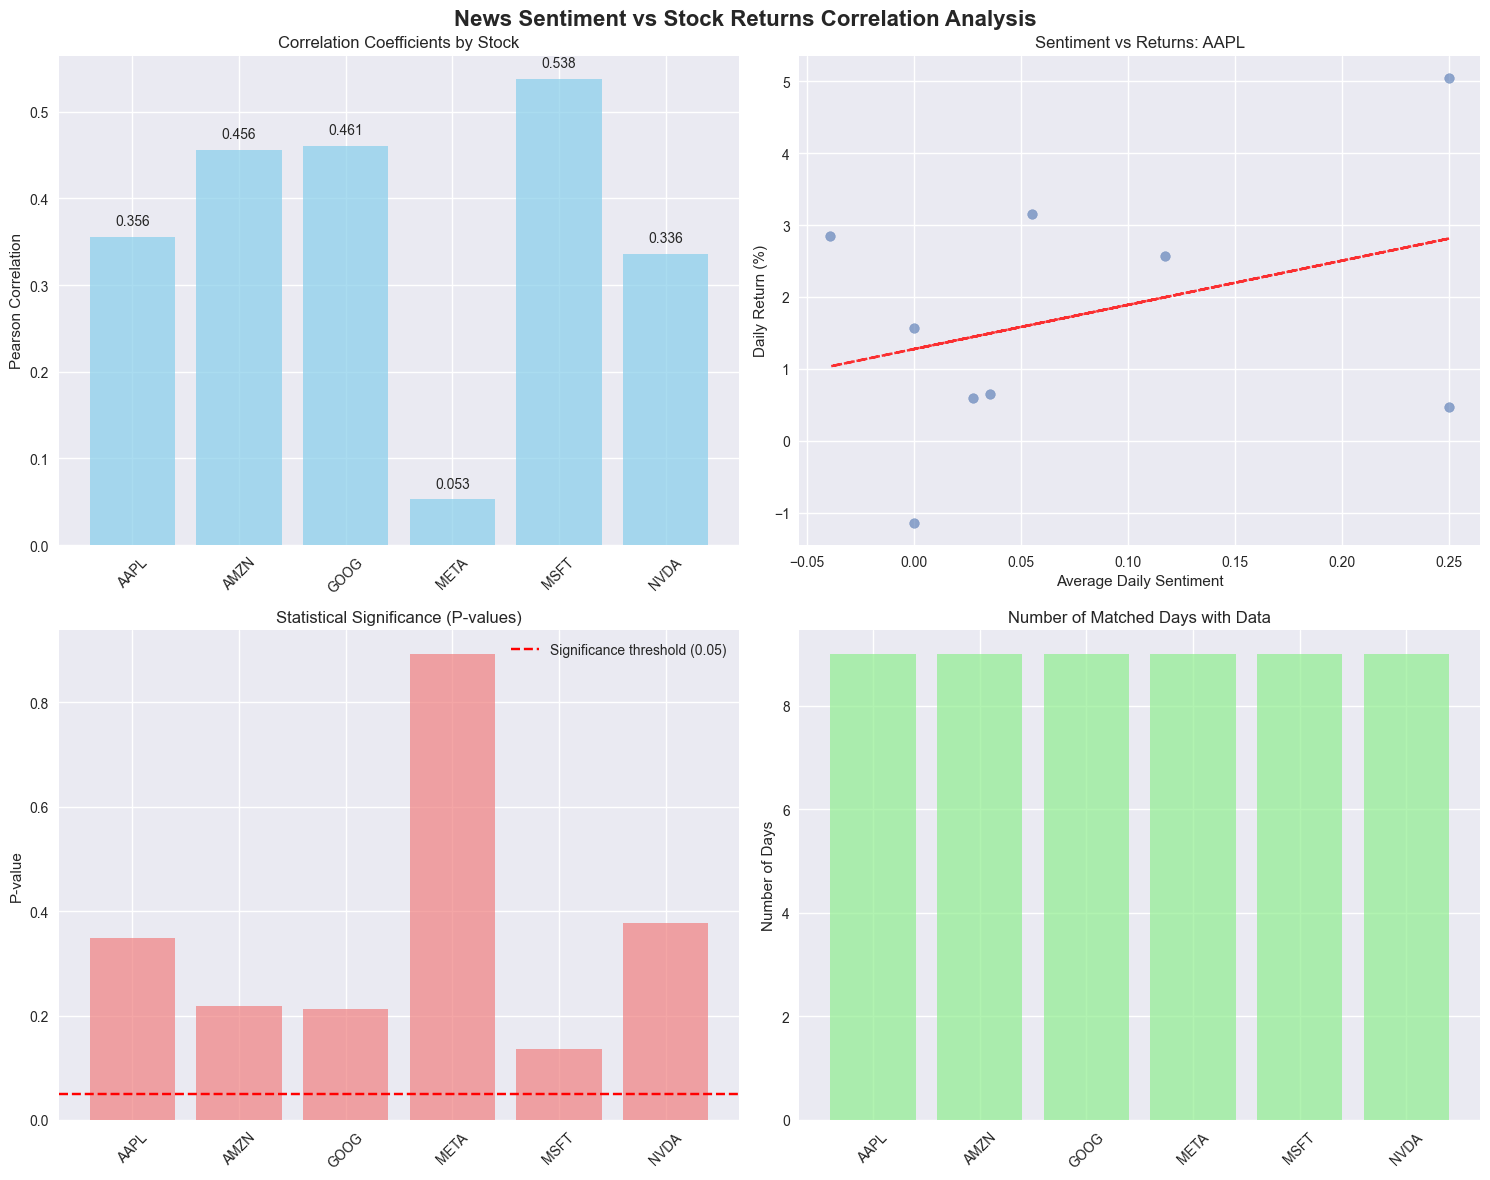

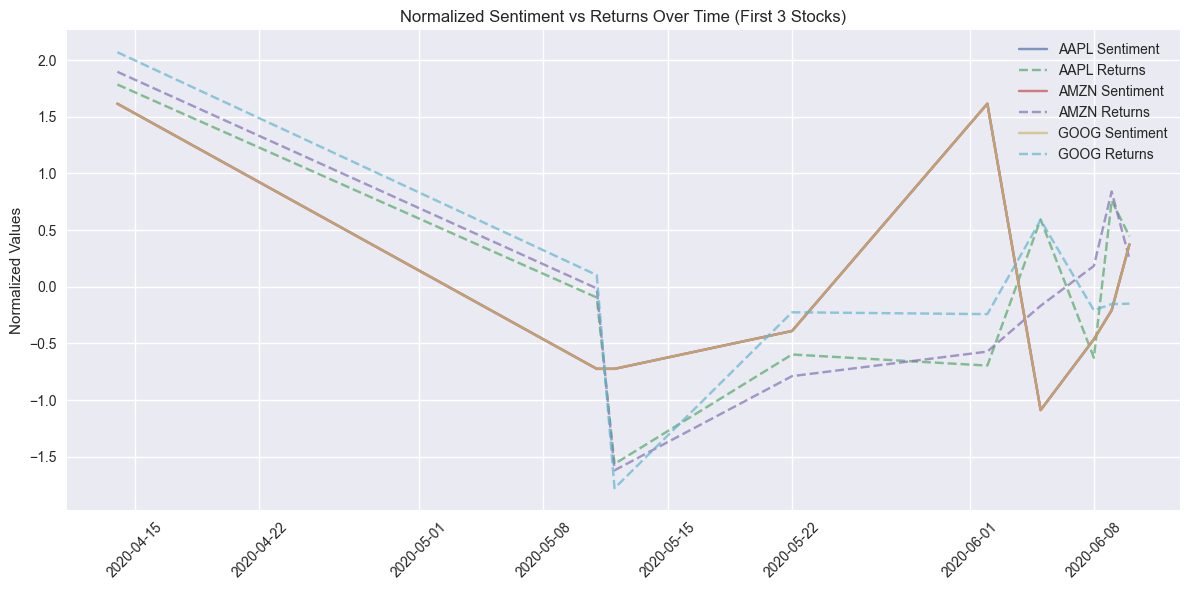


FINAL CORRELATION ANALYSIS RESULTS

📊 MSFT:
   Correlation: 0.5378 (strong positive relationship)
   P-value: 0.1353 (❌ Not significant)
   Sample Size: 9 matched days
   Avg Sentiment: 0.0775
   Avg Daily Return: 1.379%

📊 GOOG:
   Correlation: 0.4606 (strong positive relationship)
   P-value: 0.2121 (❌ Not significant)
   Sample Size: 9 matched days
   Avg Sentiment: 0.0775
   Avg Daily Return: 0.908%

📊 AMZN:
   Correlation: 0.4558 (strong positive relationship)
   P-value: 0.2175 (❌ Not significant)
   Sample Size: 9 matched days
   Avg Sentiment: 0.0775
   Avg Daily Return: 1.267%

📊 AAPL:
   Correlation: 0.3556 (strong positive relationship)
   P-value: 0.3476 (❌ Not significant)
   Sample Size: 9 matched days
   Avg Sentiment: 0.0775
   Avg Daily Return: 1.751%

📊 NVDA:
   Correlation: 0.3356 (strong positive relationship)
   P-value: 0.3773 (❌ Not significant)
   Sample Size: 9 matched days
   Avg Sentiment: 0.0775
   Avg Daily Return: 1.669%

📊 META:
   Correlation: 0.0529 (w

In [ ]:
# Cell: Improved stock filtering
def filter_news_by_stocks(news_data, target_stocks):
    """Better filtering for news data stock codes"""
    if 'stock' not in news_data.columns:
        print("❌ No 'stock' column found in news data. Using all articles.")
        return news_data
    
    print(f"\n🔍 Filtering news for target stocks: {target_stocks}")
    
    # First, let's see what stock values actually exist
    unique_stocks = news_data['stock'].unique()
    print(f"📊 All unique stock codes in data: {sorted(unique_stocks)[:50]}")  # Show first 50
    
    # Common stock code mappings in financial news
    stock_mappings = {
        'AAPL': ['AAPL', 'A', 'Apple', 'apple inc'],
        'AMZN': ['AMZN', 'A', 'Amazon', 'amazon.com'], 
        'GOOG': ['GOOG', 'GOOGL', 'G', 'Google', 'Alphabet'],
        'META': ['META', 'FB', 'F', 'Facebook', 'Meta'],
        'MSFT': ['MSFT', 'M', 'Microsoft'],
        'NVDA': ['NVDA', 'N', 'Nvidia']
    }
    
    # Create comprehensive list of patterns to match
    search_patterns = []
    for stock in target_stocks:
        if stock in stock_mappings:
            search_patterns.extend(stock_mappings[stock])
    
    # Convert to lowercase for case-insensitive matching
    search_patterns_lower = [str(pattern).lower() for pattern in search_patterns]
    
    print(f"🎯 Searching for patterns: {search_patterns_lower}")
    
    # Filter using string contains (partial matching)
    mask = news_data['stock'].astype(str).str.lower().str.contains(
        '|'.join(search_patterns_lower), na=False
    )
    
    filtered_news = news_data[mask].copy()
    
    print(f"📰 Filtered news: {len(filtered_news)}/{len(news_data)} articles for target stocks")
    if len(filtered_news) > 0:
        print(f"📰 Articles by stock after filtering:\n{filtered_news['stock'].value_counts().head(20)}")
    
    return filtered_news

# Let's also check what dates we actually have news for
def analyze_news_coverage(daily_sentiment, stock_returns):
    """Analyze date coverage between news and stock data"""
    print("\n" + "="*60)
    print("DATE COVERAGE ANALYSIS")
    print("="*60)
    
    for ticker, returns_df in stock_returns.items():
        if returns_df is not None:
            news_dates = set(daily_sentiment['Date'])
            stock_dates = set(returns_df['Date'])
            common_dates = news_dates.intersection(stock_dates)
            
            print(f"\n{ticker}:")
            print(f"  📰 News days: {len(news_dates)}")
            print(f"  📈 Stock days: {len(stock_dates)}") 
            print(f"  🔗 Common days: {len(common_dates)}")
            print(f"  📅 Stock date range: {returns_df['Date'].min().date()} to {returns_df['Date'].max().date()}")
            print(f"  📅 News date range: {daily_sentiment['Date'].min().date()} to {daily_sentiment['Date'].max().date()}")

# Updated main function with coverage analysis
def main_with_coverage():
    """Main function with coverage analysis"""
    
    STOCK_DATA_PATH = "../data/raw/yfinance_data"
    NEWS_DATA_PATH = "../data/raw/financial_news_dataset.csv"
    
    print("🚀 Starting Task 3 with Improved Filtering")
    print("="*70)
    
    # Step 1: Load data
    stock_data = load_stock_data(STOCK_DATA_PATH)
    if not stock_data:
        print("❌ Failed to load stock data")
        return
    
    news_data, text_column = load_news_data(NEWS_DATA_PATH)
    if news_data is None:
        print("❌ Failed to load news data")
        return
    
    # Step 1.5: Filter news data
    target_stocks = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']
    news_data = filter_news_by_stocks(news_data, target_stocks)
    
    # Step 2: Calculate daily sentiment
    daily_sentiment = calculate_daily_sentiment(news_data, text_column)
    
    # Step 3: Calculate stock returns
    stock_returns = {}
    for ticker in stock_data.keys():
        stock_returns[ticker] = calculate_stock_returns(stock_data, ticker)
    
    # Step 3.5: Analyze coverage
    analyze_news_coverage(daily_sentiment, stock_returns)
    
    # Step 4: Run correlation analysis
    results_df, all_merged_data = analyze_all_stocks(daily_sentiment, stock_data, stock_returns)
    
    # Step 5: Visualize results
    plot_correlation_results(results_df, all_merged_data)
    
    # Step 6: Print detailed results
    print_detailed_results(results_df)
    
    # Step 7: Save results
    if len(results_df) > 0:
        results_df.to_csv('correlation_results.csv', index=False)
        print(f"\n💾 Results saved to 'correlation_results.csv'")
        
        if all_merged_data:
            all_merged = pd.concat(all_merged_data, ignore_index=True)
            all_merged.to_csv('merged_sentiment_returns_data.csv', index=False)
            print(f"💾 Merged data saved to 'merged_sentiment_returns_data.csv'")
    
    print("\n✅ Task 3 Analysis Complete!")

# Run the improved analysis
main_with_coverage()